## Building makemore Part 3: Activations & Gradients, BatchNorm
#### https://www.youtube.com/watch?v=P6sfmUTpUmc

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open("data/names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i for i,s in enumerate(chars,1)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3
X, y = [], []

random.seed(42)
random.shuffle(words)

for name in words:
    window = [0] * block_size
    for n in name + ".":
        n = stoi[n]
        X.append(window)
        y.append(n)
        window = window[1:] + [n]

X = torch.tensor(X)
y = torch.tensor(y)

print(X.shape)
print(y.shape)

t = int(0.8*len(X))
d = int(0.9*len(X))
X_train, y_train = X[:t], y[:t]
X_val, y_val = X[t:d], y[t:d]
X_test, y_test = X[d:], y[d:]

torch.Size([228146, 3])
torch.Size([228146])


In [5]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

182516 182516
22815 22815
22815 22815


In [6]:
v_size = 10
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g)
b1 = torch.randn(h_size, generator=g)
W2 = torch.randn((h_size,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
for p in parameters:
    p.requires_grad = True

In [27]:
max_step = 200000
batch_size = 32
lr = 0.1

for i in range(max_step):

    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # Forward pass
    emb = C[X_train[ix]]
    hpreact = (emb.view(-1,block_size * v_size) @ W1) #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # Batch Normalization
    h = torch.tanh(hpreact)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y_train[ix])

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # Backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stat
    if i % 10000 == 0:
        print(f'{i:7d}/{max_step:7d}: {loss.item():.4f}')

    break

      0/ 200000: 3.2895


In [46]:
@torch.no_grad()
def check_loss(batch:str):
    batches = {"train":(X_train,y_train),
               "val":(X_val,y_val),
               "test":(X_test, y_test)}
    X = batches[batch][0]
    y = batches[batch][1]
    emb = C[X]
    hpreact = (emb.view(-1,block_size * v_size) @ W1) #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)
    
    print(f"{batch} loss: {loss}")

In [23]:
check_loss("train")
check_loss("val")

train loss: 3.3056585788726807
val loss: 3.305375337600708


- Initialization is very important in DL network
- Ideal situation is in a untuned network the logits output must be uniform, i.e, the initial output probs are equal for all labels
- Set bias to zeros
- Another problem with uisng tanh with randomly initialized W results in logits that a simply too large and this causes the output of tanh to be 1 or -1 and the derivative of tanh with 1 or -1 is zero, therefore no gradients passes through when backprop is done
- That's why ensure that 

In [10]:
# Tackling high loss during the beginning of training due to bad initilization
# Initial train loss: 2.122 and val loss: 2.158 when initilization is bad, loss in beginning 21.60

In [11]:
# By initilizing the final layer bias to 0 and multiplying final layer W values with 0.01
# This is done to fix the softmax being confidently wrong
v_size = 10
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g)
b1 = torch.randn(h_size, generator=g)
W2 = torch.randn((h_size,27), generator=g) * 0.1
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
# Initial train loss: 2.071 and val loss: 2.132 when initilization is bad, loss in beginning 3.9845

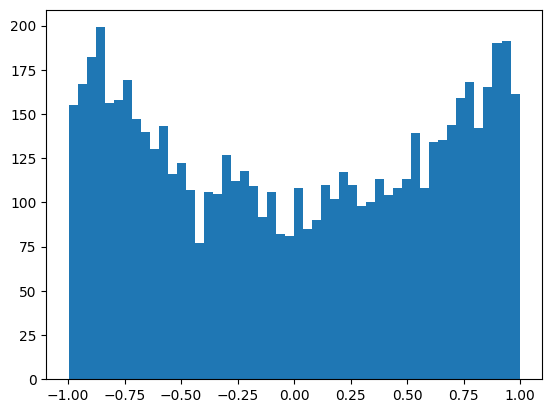

In [28]:
# Another problem with bad initilization is outputs of hiddens states being saturated (1 or -1 coming out of tanh)
plt.hist(h.view(-1).tolist(), 50);

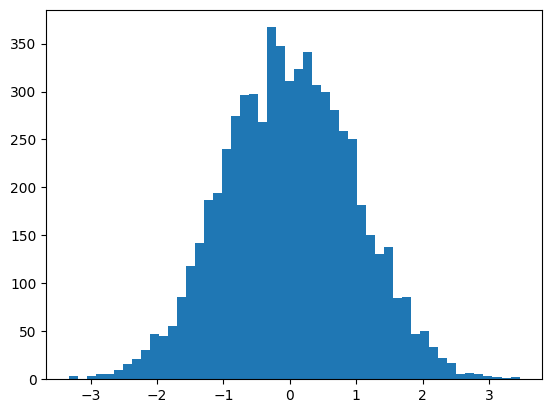

In [29]:
# Extreme values beyond -1.5 and 1.5 tends to be squashed to -1 nd 1 when passed thorugh tanh and this leads to dead neurons buring backprop
plt.hist(hpreact.view(-1).tolist(), 50);

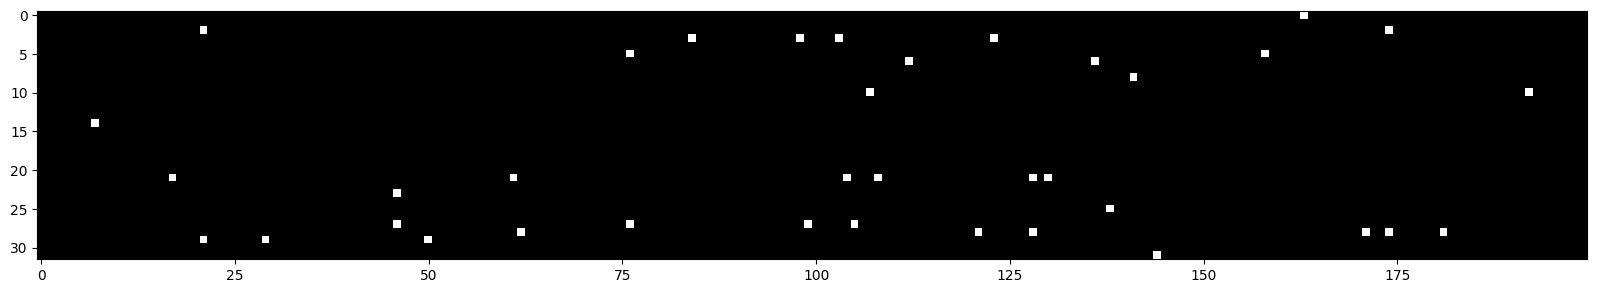

In [30]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray")
# If a whole column is white that means a neuron is dead (this neuron is saturated for all examples in mini batch)

In [15]:
# Further reduce saturation by fixing tanh layer
v_size = 10
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g) * 0.2
b1 = torch.randn(h_size, generator=g) * 0.01
W2 = torch.randn((h_size,27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
# Initial train loss: 2.0368 and val loss: 2.1030 when initilization is bad, loss in beginning 3.3275

tensor(-0.0008) tensor(1.0118)
tensor(0.0037) tensor(0.9973)


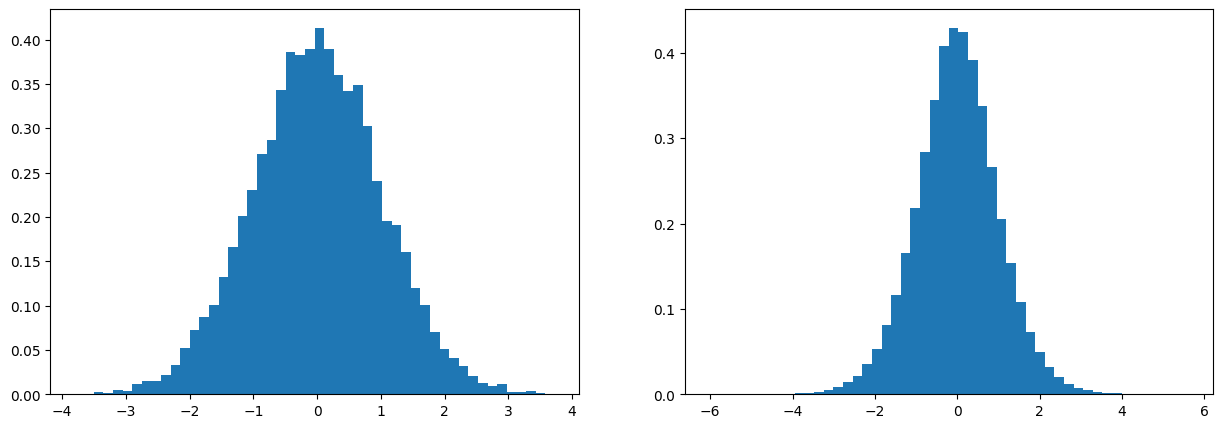

In [3]:
# It is observed that on doing matrix multiplication the variance of the values increases, this leads to exploding logits
# This can be reduced by dividing the W matrix with sqrt(n_in) where n_in represents the zeroth (row) dimension of W
# This method is called kaiming initilization
x = torch.randn(1000, 10)
W = torch.randn(10, 200) / (10**0.5)
y = x @ W
print(x.mean(), x.std())
print(y.mean(), y.std())
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax.flat[0].hist(x.view(-1).tolist(), 50, density=True); # Density param set to True converts y axis to probability density axis
ax.flat[1].hist(y.view(-1).tolist(), 50, density=True);

In [17]:
# Modern innovation on residual connectins, normalization layer, optimizers like adam-rmsprop makes not tuning initilization less forgiving

In [18]:
# Using kaiming initilization
v_size = 10 
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g) * (5/3)/((block_size * v_size)**0.5)
b1 = torch.randn(h_size, generator=g) * 0.01
W2 = torch.randn((h_size,27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
# Initial train loss: 2.0380 and val loss: 2.1060 when initilization is bad, loss in beginning 3.3104

In [31]:
hpreact.shape

torch.Size([32, 200])

In [32]:
hpreact.mean(0).shape

torch.Size([200])

In [33]:
# Batch Normlization helps achieve convergence faster
# Why is batch norm done across each dimensions of output???
hpreact.shape

torch.Size([32, 200])

In [22]:
# Introducing batch normalization scale and shift vector
v_size = 10
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g) * 0.2
b1 = torch.randn(h_size, generator=g) * 0.01
W2 = torch.randn((h_size,27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

bngain = torch.ones((1, h_size))
bnbias = torch.zeros((1, h_size))
bnmean_running = torch.zeros((1, h_size))
bnstd_running =  torch.ones((1, h_size))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
# Initial train loss: 2.0368 and val loss: 2.1030 when initilization is bad, loss in beginning 3.3275

In [24]:
# Quirk about batch norm:
# Sending examples in batches was purely done to improve efficiency, i.e. coupling examples together took advantage of parallel compute,
# batch norm operation introduces the dependency of all examples in the batches to the forward and backward pass. This strangely has as a 
# regualrizing effect (where each output of an example is dependent on whole batch, thus making it difficult for nn to overfit to memorize 
# a single example)

In [ ]:
# Batch norm is done during training but during inference the batch norm mean and standard deviation is not present since a single example 
# is being fed forward, this can be circumvented by calculating the training set mean and std and then using the same value on all
# inference examples.
# This batch norm mean and std can be calculated explicitly after training or in a running manner during training using exponentally 
# weighted mean formula as shown.

In [40]:
with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [66]:
# Batch norm doesn't need it own bias in hidden state, to understand better check out 1:01:37

In [1]:
# Writing the code in pytorch format

In [12]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/(torch.sqrt(xvar + self.eps))
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
vocab_size = 27
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [23]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], y_train[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.7513


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.72%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.81%
layer 8 (      Tanh): mean -0.01, std 0.65, saturated: 2.06%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.12%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.81%


Text(0.5, 1.0, 'activation distribution')

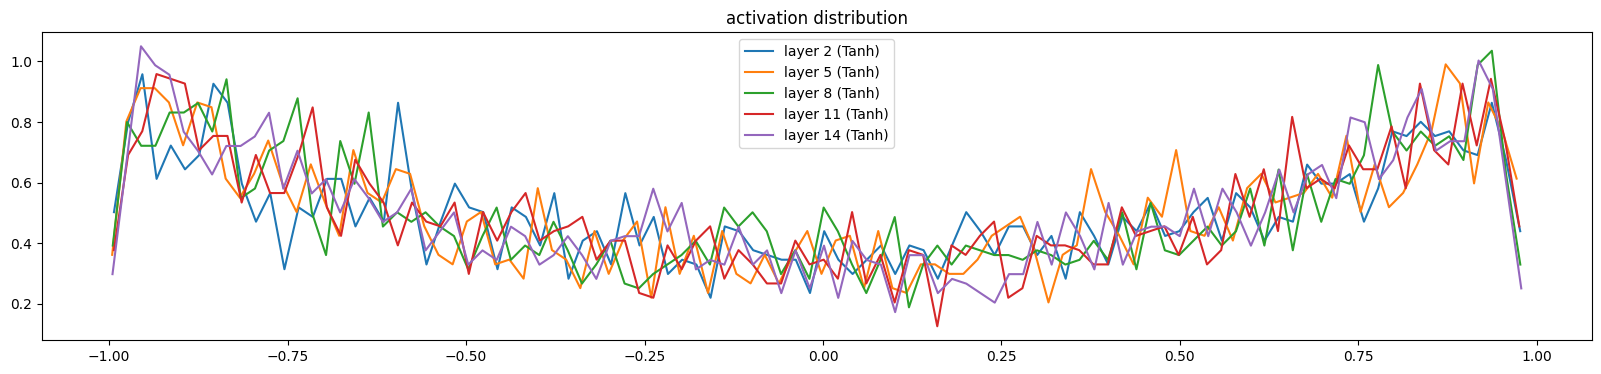

In [29]:
# Inspecting the tanh outputs through the layers of this network, without proper initilization (and appling the 5/3 gain) or batch 
# normalization we would observe the outputs of tanh shrinking to a bell curve as we move deeper into the network
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.415496e-03
layer 5 (      Tanh): mean +0.000000, std 2.889123e-03
layer 8 (      Tanh): mean -0.000000, std 2.726591e-03
layer 11 (      Tanh): mean +0.000000, std 2.507384e-03
layer 14 (      Tanh): mean -0.000000, std 2.509747e-03


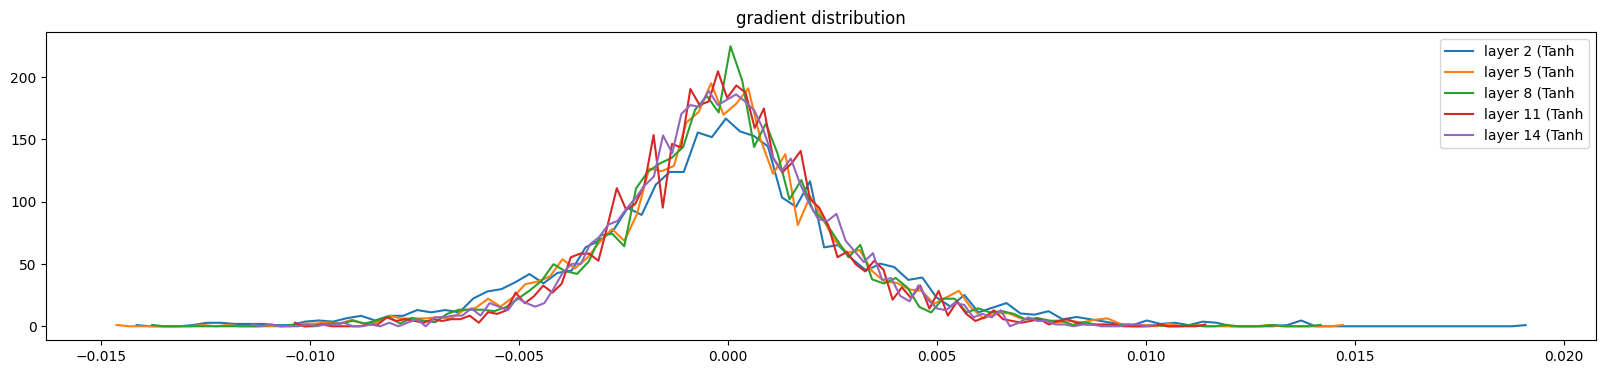

In [31]:
# It is important that the gradients remain small and all the layers have similar grad distributions, without proper initilization and 
# setting gain this would not be possible.

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000000 | std 1.020646e-02 | grad:data ratio 1.019143e-02
weight  (30, 100) | mean +0.000038 | std 7.870628e-03 | grad:data ratio 2.510047e-02
weight (100, 100) | mean -0.000014 | std 6.780632e-03 | grad:data ratio 4.024437e-02
weight (100, 100) | mean +0.000033 | std 5.796071e-03 | grad:data ratio 3.416540e-02
weight (100, 100) | mean -0.000062 | std 5.702668e-03 | grad:data ratio 3.379944e-02
weight (100, 100) | mean +0.000041 | std 4.757530e-03 | grad:data ratio 2.820421e-02
weight  (100, 27) | mean -0.000314 | std 9.139810e-03 | grad:data ratio 5.384345e-02


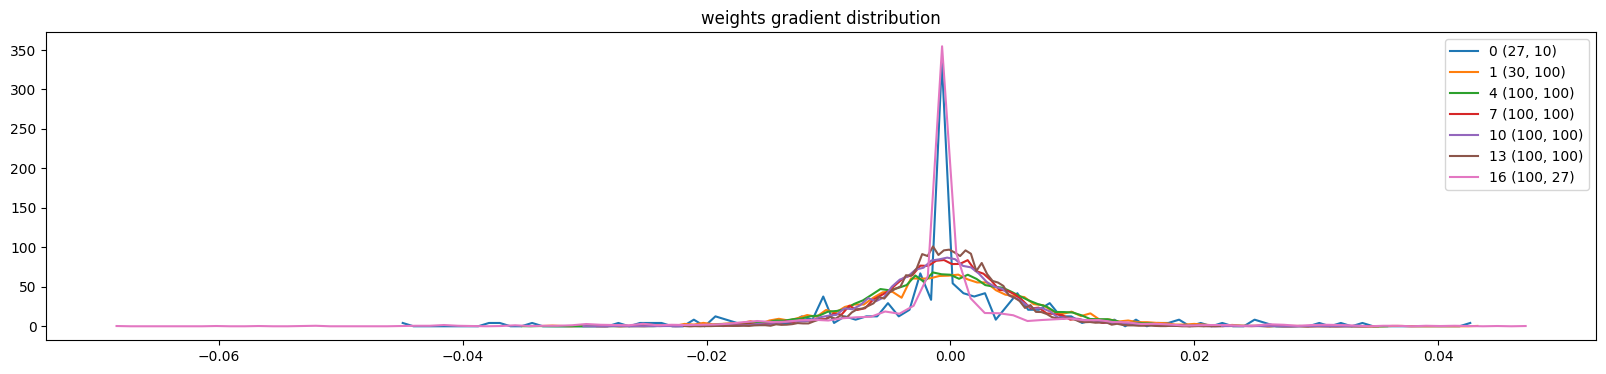

In [26]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

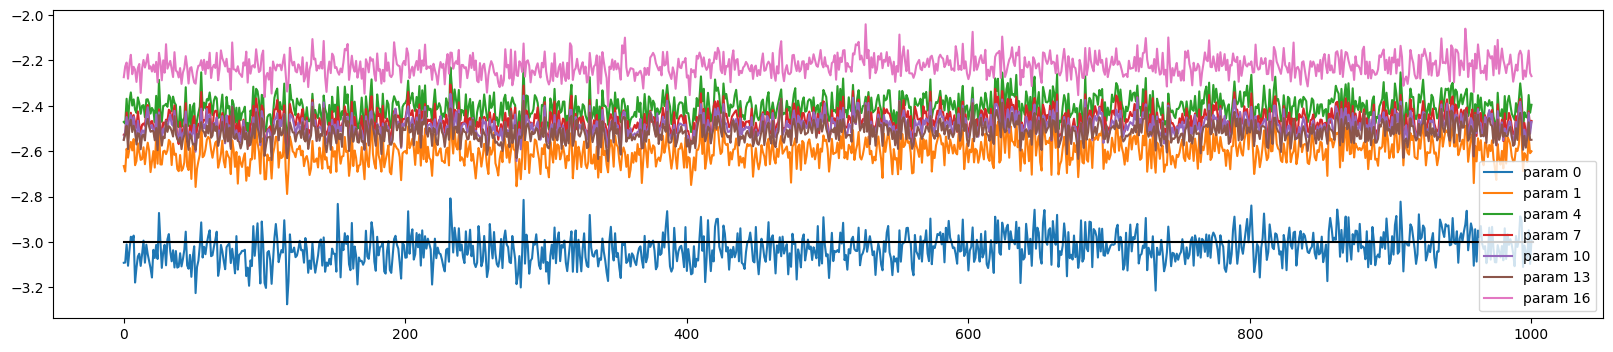

In [32]:
# Another informative plot is the ratio of update (grad * lr) to data, this should roughly be around 1e-3 or -3 in log10 scale, if it is 
# below this, then the lr is too low and if it too much above the black line then it is updating too much.
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);